<h1> Toronto Neighborhood </h1>

Explore postal codes, boroughs and neighborhoods of the city of Toronto through web scraping of the Wikipedia page.

Assumptions: Only process assigned borough is processed. Cells with a borough that is "Not assigned" are ignored.

<h2> Part 1 </h2>

In [1]:
!pip install bs4

In [2]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis

#import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
#from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import matplotlib.pyplot as plt

In [3]:
from bs4 import BeautifulSoup

In [4]:
wikiurl = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

In [5]:
req = requests.get(wikiurl)
soup=BeautifulSoup(req.content,'html5lib')
#print(soup.prettify())

In [6]:
table_contents=[]
table=soup.find('table')
#print(table)

In [7]:
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

In [8]:
#print(table_contents)

In [9]:
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [10]:
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [11]:
df.shape

(103, 3)

<h2> Part 2 </h2>

In [12]:
#!conda install -c conda-forge geocoder --yes  

In [13]:
#conda update -n base -c defaults conda

In [14]:
import geocoder

In [15]:
latitude=[]
longitude=[]

#geocoder endless loop
for PostalCode in df['PostalCode']:
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.google('{}, Toronto, Ontario'.format(PostalCode))
        lat_lng_coords = g.latlng
        print('here ',PostalCode)

    latitude.append(lat_lng_coords[0])
    longitude.append(lat_lng_coords[1])

In [16]:
csv = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv'
coords = pd.read_csv(csv)

In [17]:
coords.set_index('Postal Code', inplace = True)

In [18]:
for PostalCode in df['PostalCode']:
    coords.loc[PostalCode][1]
    latitude.append(coords.loc[PostalCode][0])
    longitude.append(coords.loc[PostalCode][1])

In [19]:
df['latitude'] = latitude
df['longitude'] = longitude

In [20]:
df.head()

,PostalCode,Borough,Neighborhood,latitude,longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


<h2> Part 3</h2>

In [21]:
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [22]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['latitude'], df['longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Only including niehgborhoods containing "Downtown"

In [23]:
downtown_data = df[df['Borough'].str.contains('Downtown')].reset_index(drop=True)
downtown_data.shape

(18, 5)

In [24]:
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [25]:
# create map of Manhattan using latitude and longitude values
map_downtown = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, label in zip(downtown_data['latitude'], downtown_data['longitude'], downtown_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_downtown)  
    
map_downtown

Using FourSquare to exlore the neighborhood

In [26]:
CLIENT_ID = '22SK3YVFFCQYZNZWNMQZ3GJKJT2YWP5FYYIOAE2YO0CE55AI' # your Foursquare ID
CLIENT_SECRET = 'CC1F5DCKC1MYEP0YZWWRDGHCW4D1LIWP4H4KH4VRBSHR50OY' # your Foursquare Secret
ACCESS_TOKEN = 'HPH2V3AKCZNMZEURLLLFUGLH3G1TSE4NHA31XREYIYBFFP3S' # your FourSquare Access Token
VERSION = '20210414' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 22SK3YVFFCQYZNZWNMQZ3GJKJT2YWP5FYYIOAE2YO0CE55AI
CLIENT_SECRET:CC1F5DCKC1MYEP0YZWWRDGHCW4D1LIWP4H4KH4VRBSHR50OY


In [27]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [28]:
downtown_venues = getNearbyVenues(downtown_data['Neighborhood'], downtown_data['latitude'], downtown_data['longitude'], radius=500)

In [29]:
downtown_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,59,59,59,59,59,59
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",16,16,16,16,16,16
Central Bay Street,66,66,66,66,66,66
Christie,16,16,16,16,16,16
Church and Wellesley,73,73,73,73,73,73
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Enclave of M5E,97,97,97,97,97,97
"First Canadian Place, Underground city",100,100,100,100,100,100
"Garden District, Ryerson",100,100,100,100,100,100


In [30]:
print('There are {} uniques categories.'.format(len(downtown_venues['Venue Category'].unique())))

There are 207 uniques categories.


In [31]:
# one hot encoding
downtown_onehot = pd.get_dummies(downtown_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
downtown_onehot['Toronto_Neighborhood'] = downtown_venues['Neighborhood']
downtown_onehot.shape

# move neighborhood column to the first column
fixed_columns = [downtown_onehot.columns[-1]] + list(downtown_onehot.columns[:-1])
downtown_onehot = downtown_onehot[fixed_columns]

downtown_onehot.shape

(1193, 208)

In [32]:
downtown_onehot.head()

,Toronto_Neighborhood,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Theme Restaurant,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
downtown_grouped = downtown_onehot.groupby('Toronto_Neighborhood').mean().reset_index()
downtown_grouped.shape

(18, 208)

function to sort types of venue in descending order

In [34]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [35]:
num_top_venues = 6

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = downtown_grouped['Toronto_Neighborhood']

for ind in np.arange(downtown_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(downtown_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Cheese Shop,Seafood Restaurant,Farmers Market,Bakery
1,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Harbor / Marina,Sculpture Garden,Airport Food Court,Airport Gate
2,Central Bay Street,Coffee Shop,Sandwich Place,Café,Italian Restaurant,Burger Joint,Salad Place
3,Christie,Grocery Store,Café,Park,Nightclub,Restaurant,Italian Restaurant
4,Church and Wellesley,Sushi Restaurant,Coffee Shop,Japanese Restaurant,Restaurant,Hotel,Pub


Clustering

In [36]:
downtown_grouped_clustering = downtown_grouped.drop(['Toronto_Neighborhood'], 1)

In [37]:
#find best K
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(downtown_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

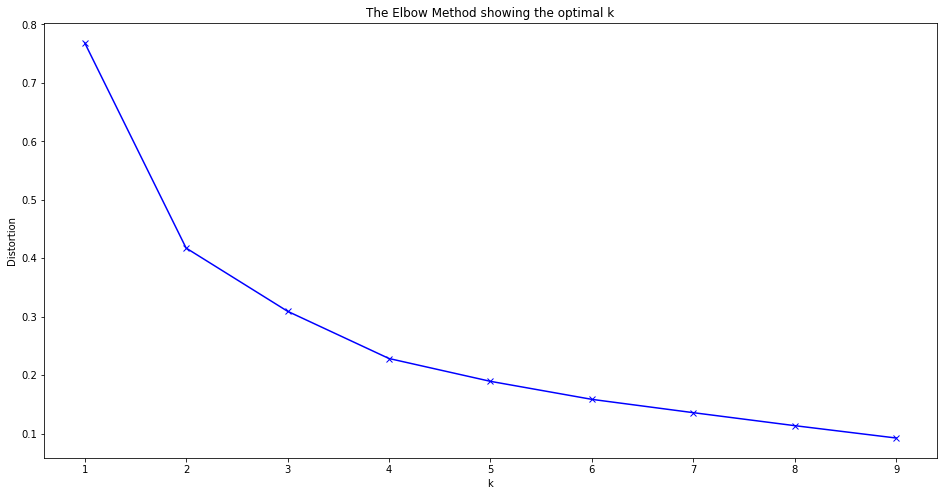

In [38]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [39]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(downtown_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:30] 

array([1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1])

In [40]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

downtown_merged = downtown_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
downtown_merged = downtown_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

downtown_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,Coffee Shop,Bakery,Pub,Café,Park,Breakfast Spot
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,1,Coffee Shop,Clothing Store,Cosmetics Shop,Middle Eastern Restaurant,Bubble Tea Shop,Japanese Restaurant
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,1,Coffee Shop,Café,Cocktail Bar,Clothing Store,Cosmetics Shop,Gastropub
3,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,1,Coffee Shop,Cocktail Bar,Cheese Shop,Seafood Restaurant,Farmers Market,Bakery
4,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,1,Coffee Shop,Sandwich Place,Café,Italian Restaurant,Burger Joint,Salad Place


In [41]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(downtown_merged['latitude'], downtown_merged['longitude'], downtown_merged['Neighborhood'], downtown_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [42]:
downtown_merged.loc[downtown_merged['Cluster Labels'] == 0, downtown_merged.columns[[1]+[2] + list(range(5, downtown_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
13,Downtown Toronto,Rosedale,0,Park,Playground,Trail,Dessert Shop,Escape Room,Electronics Store


In [43]:
downtown_merged.loc[downtown_merged['Cluster Labels'] == 1, downtown_merged.columns[[1]+[2] + list(range(5, downtown_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
0,Downtown Toronto,"Regent Park, Harbourfront",1,Coffee Shop,Bakery,Pub,Café,Park,Breakfast Spot
1,Downtown Toronto,"Garden District, Ryerson",1,Coffee Shop,Clothing Store,Cosmetics Shop,Middle Eastern Restaurant,Bubble Tea Shop,Japanese Restaurant
2,Downtown Toronto,St. James Town,1,Coffee Shop,Café,Cocktail Bar,Clothing Store,Cosmetics Shop,Gastropub
3,Downtown Toronto,Berczy Park,1,Coffee Shop,Cocktail Bar,Cheese Shop,Seafood Restaurant,Farmers Market,Bakery
4,Downtown Toronto,Central Bay Street,1,Coffee Shop,Sandwich Place,Café,Italian Restaurant,Burger Joint,Salad Place
6,Downtown Toronto,"Richmond, Adelaide, King",1,Coffee Shop,Café,Restaurant,Clothing Store,Deli / Bodega,Thai Restaurant
7,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",1,Coffee Shop,Aquarium,Café,Hotel,Restaurant,Fried Chicken Joint
8,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",1,Coffee Shop,Hotel,Café,Restaurant,Japanese Restaurant,Italian Restaurant
9,Downtown Toronto,"Commerce Court, Victoria Hotel",1,Coffee Shop,Restaurant,Café,Hotel,Gym,Italian Restaurant
10,Downtown Toronto,"University of Toronto, Harbord",1,Café,Yoga Studio,Bar,Italian Restaurant,Japanese Restaurant,Bookstore


In [44]:
downtown_merged.loc[downtown_merged['Cluster Labels'] == 2, downtown_merged.columns[[1]+[2]+ list(range(5, downtown_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
12,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",2,Airport Lounge,Airport Service,Harbor / Marina,Sculpture Garden,Airport Food Court,Airport Gate


In [45]:
downtown_merged.loc[downtown_merged['Cluster Labels'] == 3, downtown_merged.columns[[1]+[2]+ list(range(5, downtown_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
5,Downtown Toronto,Christie,3,Grocery Store,Café,Park,Nightclub,Restaurant,Italian Restaurant


In [46]:
downtown_merged["Cluster Labels"].astype(str).dtypes

dtype('O')

In [47]:
downtown_merged["Cluster Labels"].replace({0: "Parkland", 1: "Trendy",2:"Airport",3:"Quiet Residential"}, inplace=True)

In [48]:
downtown_merged

,PostalCode,Borough,Neighborhood,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Trendy,Coffee Shop,Bakery,Pub,Café,Park,Breakfast Spot
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,Trendy,Coffee Shop,Clothing Store,Cosmetics Shop,Middle Eastern Restaurant,Bubble Tea Shop,Japanese Restaurant
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,Trendy,Coffee Shop,Café,Cocktail Bar,Clothing Store,Cosmetics Shop,Gastropub
3,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,Trendy,Coffee Shop,Cocktail Bar,Cheese Shop,Seafood Restaurant,Farmers Market,Bakery
4,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,Trendy,Coffee Shop,Sandwich Place,Café,Italian Restaurant,Burger Joint,Salad Place
5,M6G,Downtown Toronto,Christie,43.669542,-79.422564,Quiet Residential,Grocery Store,Café,Park,Nightclub,Restaurant,Italian Restaurant
6,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,Trendy,Coffee Shop,Café,Restaurant,Clothing Store,Deli / Bodega,Thai Restaurant
7,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,Trendy,Coffee Shop,Aquarium,Café,Hotel,Restaurant,Fried Chicken Joint
8,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,Trendy,Coffee Shop,Hotel,Café,Restaurant,Japanese Restaurant,Italian Restaurant
9,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817,Trendy,Coffee Shop,Restaurant,Café,Hotel,Gym,Italian Restaurant
